In [ ]:
from tqdm import tqdm
import random
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import scipy.sparse as sp
from omegaconf import OmegaConf
from copy import deepcopy
from cfgen.data.scrnaseq_loader import RNAseqLoader
from cfgen.models.base.encoder_model import EncoderModel
from cfgen.models.fm.fm import FM
from scvi.distributions import NegativeBinomial

sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(4, 4)) 

## Initialize dataset and encoder

In [ ]:
dataset_conf = OmegaConf.load("../../configs/configs_sccfm/dataset/pbmc3k.yaml")
encoder_conf = OmegaConf.load("../../configs/configs_encoder/encoder/default.yaml")

In [ ]:
dataset_conf

Initialize dataset

In [ ]:
dataset = RNAseqLoader(dataset_conf.dataset_path,
                        layer_key=dataset_conf.layer_key,
                        covariate_keys=dataset_conf.covariate_keys,
                        subsample_frac=dataset_conf.subsample_frac, 
                        normalization_type=dataset_conf.normalization_type,
                        is_binarized=dataset_conf.is_binarized)

dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size=64,
                                        shuffle=False,
                                        drop_last=False)

in_dim = dataset.X["rna"].shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

n_cat = len(dataset.id2cov["cell_type"])

Initialize Autoencoder

In [ ]:
gene_dim = {mod: dataset.X[mod].shape[1] for mod in dataset.X}

encoder_model = EncoderModel(in_dim=gene_dim,
                              n_cat=None,
                              conditioning_covariate=dataset_conf.theta_covariate, 
                              **encoder_conf)

In [ ]:
state_dict_path = "../../project_folder/experiments/autoencoder_ckpt/train_autoencoder_pbmc3k_final/checkpoints/last.ckpt"
encoder_model.load_state_dict(torch.load(state_dict_path, weights_only=False)["state_dict"])

## Initialize Flow Matching model

In [ ]:
generative_model_config = OmegaConf.load("../../configs/configs_sccfm/generative_model/default.yaml")

In [ ]:
ckpt = torch.load("../../project_folder/experiments/cfgen_ckpt/train_fm_pbmc3k_final/last.ckpt", weights_only=False)

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [ ]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

In [63]:
generative_model = FM(encoder_model=encoder_model,
                        denoising_model=denoising_model,
                        feature_embeddings=feature_embeddings,
                        plotting_folder=None,
                        in_dim={"rna": 50},
                        size_factor_statistics=size_factor_statistics,
                        covariate_list=["cell_type"],
                        theta_covariate="cell_type",
                        size_factor_covariate="cell_type",
                        is_binarized=False,
                        modality_list=["rna"],
                        guidance_weights={"cell_type": 1.5},
                        **generative_model_config  # model_kwargs should contain the rest of the arguments
                        )

# generative_model.denoising_model.embed_size_factor = True
generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (encoder): ModuleDict(
      (rna): MLP(
        (net): Sequential(
          (0): Sequential(
            (0): Linear(in_features=8573, out_features=512, bias=True)
            (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (1): Sequential(
            (0): Linear(in_features=512, out_features=256, bias=True)
            (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (2): Linear(in_features=256, out_features=50, bias=True)
        )
      )
    )
    (decoder): ModuleDict(
      (rna): MLP(
        (net): Sequential(
          (0): Sequential(
            (0): Linear(in_features=50, out_features=256, bias=True)
            (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (

## Load real dataset 

In [64]:
adata_original = sc.read_h5ad(dataset_conf["dataset_path"])
adata_original.X = adata_original.layers["X_counts"].copy()
adata_original.obs["size_factor"]=adata_original.X.toarray().sum(1)

In [65]:
adata_original 

AnnData object with n_obs × n_vars = 2110 × 8573
    obs: 'n_genes', 'percent_mito', 'n_counts', 'cell_type', 'size_factor'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'connectivities', 'distances'

## Generate and save cells

In [66]:
unique_classes = np.unique(adata_original.obs.cell_type, return_counts=True)
unique_classes = dict(zip(unique_classes[0], unique_classes[1]))
unique_classes

{'B cells': np.int64(250),
 'CD14+ Monocytes': np.int64(390),
 'CD4 T cells': np.int64(927),
 'CD8 T cells': np.int64(248),
 'Dendritic cells': np.int64(31),
 'FCGR3A+ Monocytes': np.int64(124),
 'Megakaryocytes': np.int64(14),
 'NK cells': np.int64(126)}

In [67]:
# Generate in batches -- roughly 18k cells
num_indices = 2000
index_range = len(adata_original)

# Sample conditions from the data (roughly keeps the same observed proportions)
indices = random.sample(range(index_range), num_indices)
adata_indices = adata_original[indices]

classes_str =  list(adata_indices.obs.cell_type)
classes = {"cell_type": torch.tensor([dataset.id2cov["cell_type"][c] for  c in classes_str])}

log_size_factors = {"rna": torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()}
X_generated = generative_model.batched_sample(batch_size=200,
                                                repetitions=10,
                                                n_sample_steps=2, 
                                                theta_covariate="cell_type", 
                                                size_factor_covariate="cell_type", 
                                                conditioning_covariates=["cell_type"],
                                                covariate_indices=classes, 
                                                log_size_factor=log_size_factors)

X_generated = X_generated["rna"].to("cpu")

In [68]:
X_generated = X_generated.numpy()

In [69]:
dataset_type = ["Real" for _ in range(adata_original.shape[0])] + ["Generated" for _ in range(X_generated.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]
dataset_type["cell_type"] = list(adata_original.obs.cell_type)+list(classes_str)

In [70]:
adata_merged = sc.AnnData(X=np.concatenate([adata_original.X.toarray(), X_generated], axis=0), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [71]:
sc.pp.normalize_total(adata_merged, target_sum=1e4)
sc.pp.log1p(adata_merged)

In [72]:
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

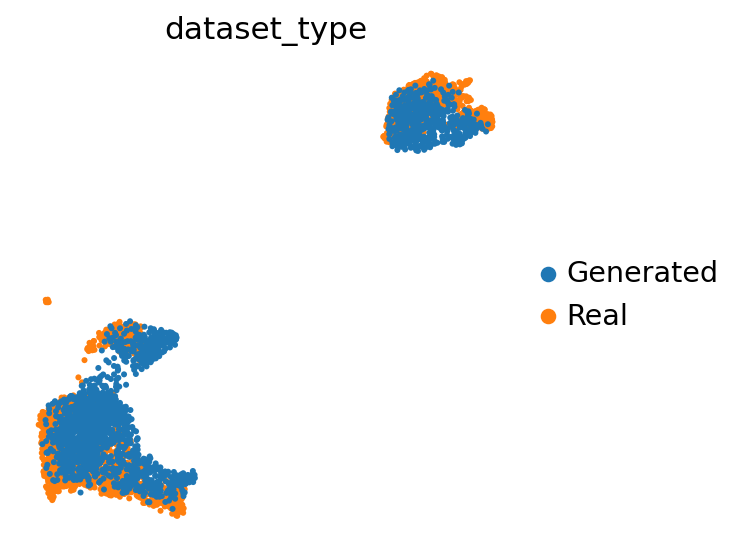

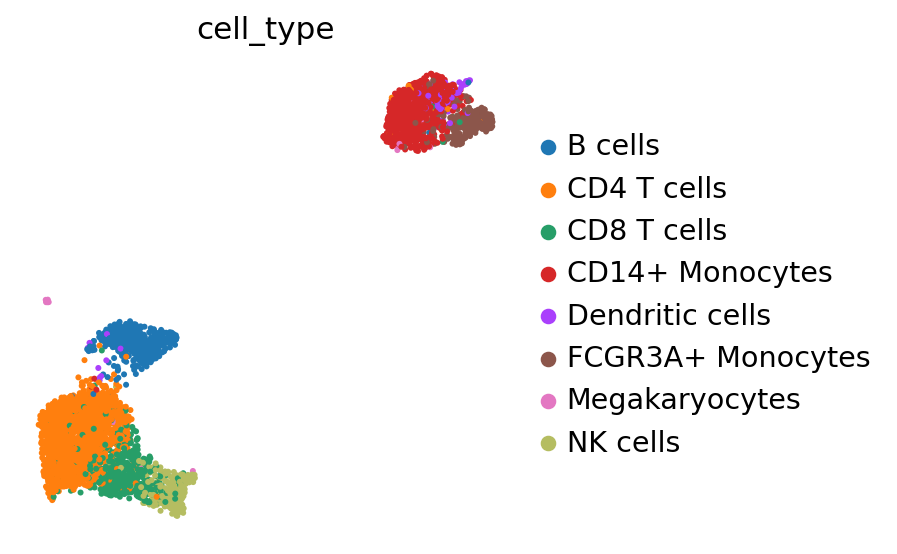

In [73]:
sc.pl.umap(adata_merged, color="dataset_type")
sc.pl.umap(adata_merged, color="cell_type")